In [4]:
import os
from typing import Tuple, List, Sequence, Callable, Dict

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.python.client import device_lib
import tensorflow as tf

import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import KeypointRCNN

import albumentations as A
from albumentations.pytorch import ToTensorV2

device_lib.list_local_devices()

tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
df = pd.read_csv('E:/data/train_df.csv', index_col='image')
df.head()

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
image,,,,,,,,,,,,,,,,,,,,,
001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,343.000000,...,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,333.968459,...,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,334.109461,...,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,359.351579,...,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,338.187380,...,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102


## 1. 데이터셋 전처리 및 시각화

In [6]:
def draw_keypoints(
    image: np.ndarray,
    keypoints: np.ndarray,
    edges: List[Tuple[int, int]] = None,
    keypoint_names: Dict[int, str] = None, 
    boxes: bool = True,
    dpi: int = 200
) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))): 
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}

    if boxes:
        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, 
            tuple(keypoint), 
            3, colors.get(i), thickness=3, lineType=cv2.FILLED)

        if keypoint_names is not None:
            cv2.putText(
                image, 
                f'{i}: {keypoint_names[i]}', 
                tuple(keypoint), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    if edges is not None:
        for i, edge in enumerate(edges):
            cv2.line(
                image, 
                tuple(keypoints[edge[0]]), 
                tuple(keypoints[edge[1]]),
                colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(dpi=dpi)
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    fig.savefig('example.png')

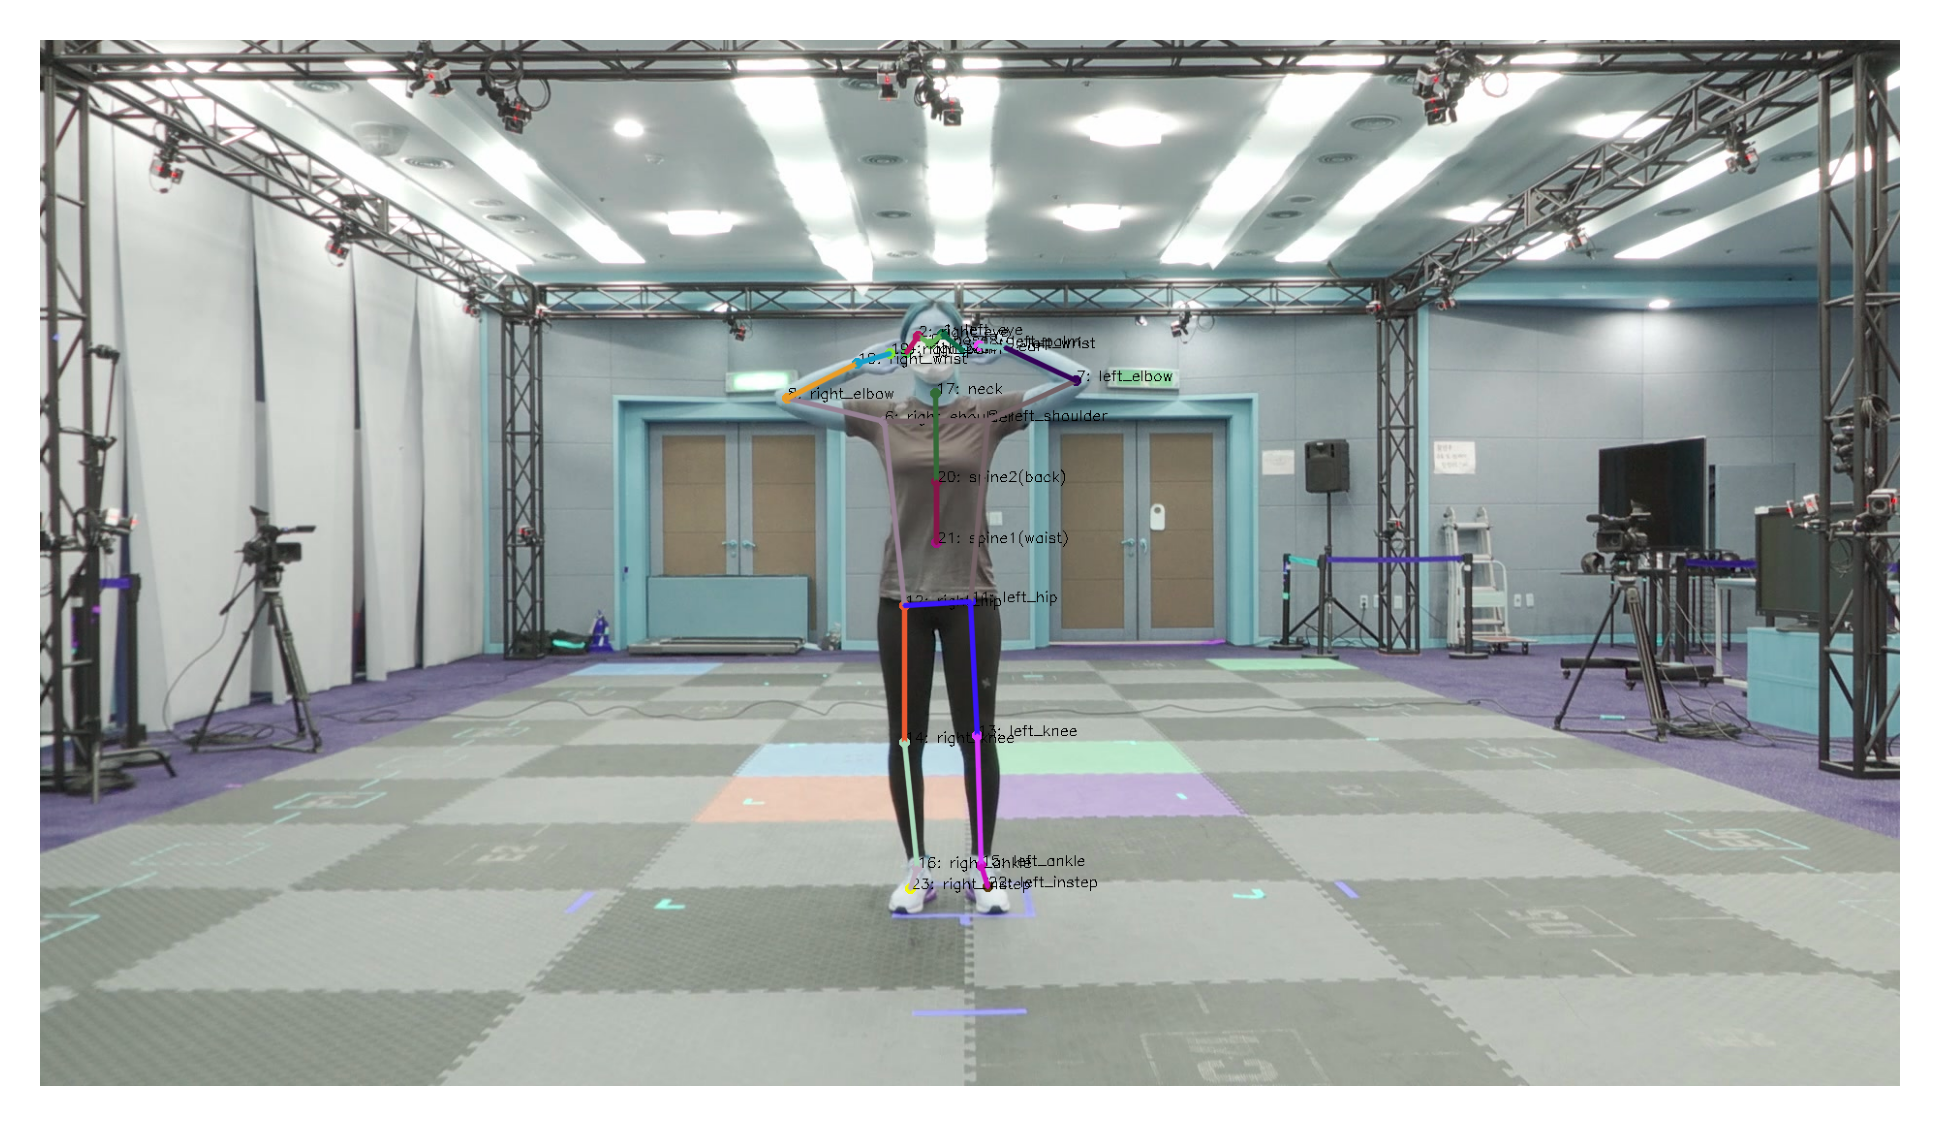

In [11]:
keypoints = df.loc['002-1-1-01-Z17_C-0000011.jpg'].values.reshape(-1, 2)
keypoints = keypoints.astype(np.int64)
keypoint_names = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear', 
    4: 'right_ear', 
    5: 'left_shoulder', 
    6: 'right_shoulder',
    7: 'left_elbow', 
    8: 'right_elbow',
    9: 'left_wrist', 
    10: 'right_wrist',
    11: 'left_hip', 
    12: 'right_hip',
    13: 'left_knee', 
    14: 'right_knee',
    15: 'left_ankle', 
    16: 'right_ankle',
    17: 'neck', 
    18: 'left_palm', 
    19: 'right_palm', 
    20: 'spine2(back)',
    21: 'spine1(waist)', 
    22: 'left_instep',
    23: 'right_instep'
}

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
    (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
    (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
    (6, 12), (11, 12), (17, 20), (20, 21), 
]

image = cv2.imread('E:/data/train_imgs/002-1-1-01-Z17_C-0000011.jpg', cv2.COLOR_BGR2RGB)
draw_keypoints(image, keypoints, edges, keypoint_names, boxes=False, dpi=400)

## 2. torchvision 모형을 이용한 추론

In [12]:
image = cv2.imread('E:/data/train_imgs/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1333, 800))
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]

model = keypointrcnn_resnet50_fpn(pretrained=True, progress=False)
model.eval()
preds = model(image)
preds[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])

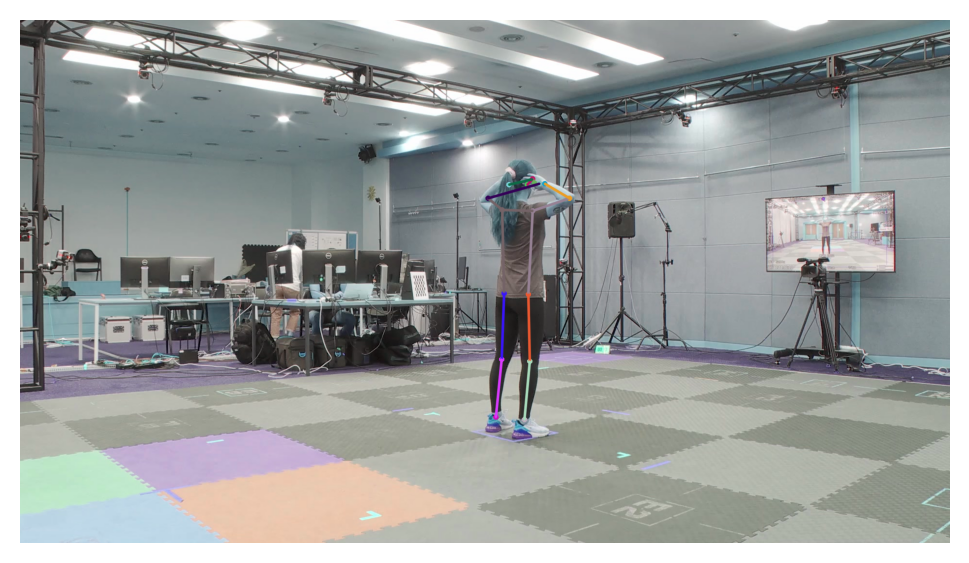

In [13]:
keypoints = preds[0]['keypoints'].detach().numpy().copy()[0]
image = cv2.imread('E:/data/train_imgs/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)
keypoints[:, 0] *= image.shape[1]/1333
keypoints[:, 1] *= image.shape[0]/800
keypoints = keypoints[:, :2]

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
    (12, 14), (14, 16), (5, 6)
]

draw_keypoints(image, keypoints, edges, boxes=False)

## 3. Keypoint R-CNN 학습하기

`torchvision`의 `Keypoint R-CNN`을 사용하실려면, 사실 다른 SOTA 모형들도 비슷하지만, Bounding box 좌표가 들어갑니다.
본 대회 데이터셋에는 박스 좌표가 없기 때문에 키포인트에서 뽑았습니다. 나머지는 MS COCO 포맷을 따릅니다.

In [14]:
class KeypointDataset(Dataset):
    def __init__(
        self,
        image_dir: os.PathLike,
        label_path: os.PathLike,
        transforms: Sequence[Callable]=None
    ) -> None:
        self.image_dir = image_dir
        self.df = pd.read_csv(label_path)
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index: int) -> Tuple[Tensor, Dict]:
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)

        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.COLOR_BGR2RGB)

        targets ={
            'image': image,
            'bboxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        if self.transforms is not None:
            targets = self.transforms(**targets)

        image = targets['image']
        image = image / 255.0

        targets = {
            'labels': torch.as_tensor(targets['labels'], dtype=torch.int64),
            'boxes': torch.as_tensor(targets['bboxes'], dtype=torch.float32),
            'keypoints': torch.as_tensor(
                np.concatenate([targets['keypoints'], np.ones((24, 1))], axis=1)[np.newaxis], dtype=torch.float32
            )
        }

        return image, targets

`albumentations`은 공식 문서를 참고해 어그멘테이션 기법들을 추가하시면 되겠습니다.

In [15]:
transforms = A.Compose([
    ToTensorV2()
],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
    keypoint_params=A.KeypointParams(format='xy')
)

In [17]:
def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))


trainset = KeypointDataset('E:/data/train_imgs/', 'E:/data/train_df.csv', transforms)
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=8, collate_fn=collate_fn)


In [18]:
def get_model() -> nn.Module:
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    keypoint_roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=14,
        sampling_ratio=2
    )

    model = KeypointRCNN(
        backbone, 
        num_classes=2,
        num_keypoints=24,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=keypoint_roi_pooler
    )

    return model

In [19]:
def train(device='cuda:0'):
    model = get_model()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for i, (images, targets) in enumerate(train_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            losses = model(images, targets)
    
            loss = sum(loss for loss in losses.values())
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print(f'| epoch: {epoch} | loss: {loss.item():.4f}', end=' | ')
                for k, v in losses.items():
                    print(f'{k[5:]}: {v.item():.4f}', end=' | ')
                print()

## 4. 학습한 모형에서 추론

In [31]:
from eval import get_model


image = cv2.imread('E/data/test_imgs/697-3-5-34-Z94_C-0000013.jpg', cv2.COLOR_BGR2RGB)
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]

model = get_model()
model.load_state_dict(torch.load('model-e39.pth'))
model.eval()
preds = model(image)
keypoints = preds[0]['keypoints'].detach().numpy().copy()[0]
image = cv2.imread('E/data/test_imgs/697-3-5-34-Z94_C-0000013.jpg', cv2.COLOR_BGR2RGB)
keypoints = keypoints[:, :2]

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
    (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
    (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
    (6, 12), (11, 12), (17, 20), (20, 21), 
]

draw_keypoints(image, keypoints, edges, boxes=False)

ModuleNotFoundError: No module named 'eval'